# Simulation experiment for detection thresholds for variant calling

This notebook is to get detection thresholds for the limit of the variant calling based on: 

1. Read depth
2. Error rate
3. Number of mutations

The data from this comes from: https://pubs.acs.org/doi/10.1021/acscentsci.7b00548 Ape AGW


In [9]:
import pandas as pd
# Visualisation things to make the figures look nice
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sciutil import SciUtil


data_dir = 'ePCR_data/'
fig_dir = 'ePCR_figures/'


plt.rcParams['svg.fonttype'] = 'none'
axis_line_width = 1.0
axis_font_size = 12
title_font_size = 12
label_font_size = 10
figsize = (2.5, 3) # Figure size
font = 'Arial'
style = 'ticks'
font_family = 'sans-serif'

# Create a figure with 2x2 subplots
cmap = 'viridis'
palette = sns.color_palette("viridis_r", as_cmap=True)
sns.set_palette(cmap)

sns.set(rc={'figure.figsize': figsize, 'font.family': font_family,
            'font.sans-serif': font, 'font.size': label_font_size}, style=style)
sns.set_style("ticks")

def set_ax_params(ax):
    ax.tick_params(direction='out', length=2, width=axis_line_width)
    ax.spines['bottom'].set_linewidth(axis_line_width)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(axis_line_width)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=axis_font_size)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    ax.tick_params(labelsize=label_font_size)


u = SciUtil()

# Generate mutations on a "real" sequence
# Decided to choose tauD from Ecoli K12
parent_sequence_aa = 'MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACDVLKDQVDEILDLAGGWVASNEHLIYYFSNPDTGEPIKEYLERVRARFGAWILDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTVPHIPLRYLIAWIYPITATIKPFLAKKGGSPEDIEGMYNAWFKSVVLQVAIWSHPYTKENDWLEHHHHHH*'

parent_sequence = 'ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCACGGACCTTGAGTTTGACCTTCTGAAGAAGACTGTCATGTTAGGTGAAAAGGACGTAATGTACTTGAAAAAGGCGTGTGACGTTCTGAAAGATCAAGTTGATGAGATCCTTGACTTGGCGGGTGGTTGGGTAGCATCAAATGAGCATTTGATTTATTACTTCTCCAATCCGGATACAGGAGAGCCTATTAAGGAATACCTGGAACGTGTACGCGCTCGCTTTGGAGCCTGGATTCTGGACACTACCTGCCGCGACTATAACCGTGAATGGTTAGACTACCAGTACGAAGTTGGGCTTCGTCATCACCGTTCAAAGAAAGGGGTCACAGACGGAGTACGCACCGTGCCCCATATCCCACTTCGTTATCTTATCGCATGGATCTATCCTATCACCGCCACTATCAAGCCATTTTTGGCTAAGAAAGGTGGCTCTCCGGAAGACATCGAAGGGATGTACAACGCTTGGTTCAAGTCTGTAGTTTTACAAGTTGCCATCTGGTCACACCCTTATACTAAGGAGAATGACTGGCTCGAGCACCACCACCACCACCACTGA'

# Introduce mutations at a given frequency and an error rate

Test setup:

Change to 0.1 - 5% 0.2% step size. 

1. For number of mutations from 1 to the sequence length test mutating each one and correlate this to the p value
2. For sequencing error rates from 0 to 100% make sequences ranging with this and see what the results are for the p value and the error
3. For different sequence lengths also check how sequence length corresponds to the pvalue

In [37]:
from minION import *
from tqdm import tqdm

label = 'ParLQ'

In [38]:
significance = -1*np.log10(0.001)

## Experiment 1: Varying the sequencing error rate for a single mutation

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_70709/2958729570.py:2: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)


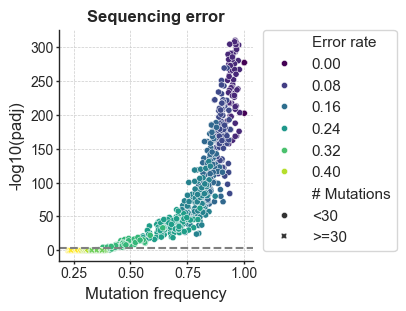

In [39]:

experiment_df = pd.read_csv(f'{data_dir}Experiment1.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Error rate'] = [int(c.split('_')[-1])/100.0 for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df['# Mutations'] = [f'<30' if v < 30 else f'>=30' for v in experiment_df['# Mutations']]
experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Error rate', palette='viridis', 
                    style="# Mutations", style_order=['<30', '>=30'], s=20)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Sequencing error', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.savefig(f'{fig_dir}Experiment1_{label}.svg')
plt.show()

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_70709/2510296329.py:2: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)


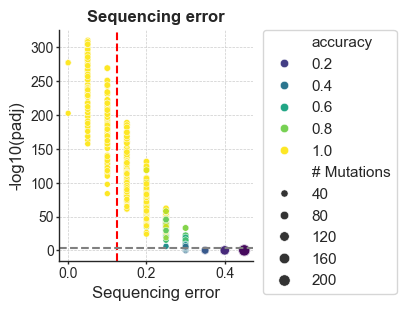

In [40]:

experiment_df = pd.read_csv(f'{data_dir}Experiment1.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Error rate'] = [int(c.split('_')[-1])/100.0 for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='Error rate', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")
set_ax_params(ax)
plt.xlabel('Sequencing error')
plt.ylabel('-log10(padj)')
plt.title('Sequencing error', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(x = 0.125, color = 'red', linestyle = '--') #axis='y', 

plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.savefig(f'{fig_dir}Experiment1_version2_{label}.svg')
plt.show()

In [41]:
experiment_df

,level_0,index,Plate,Well,Path,Alignment_count,P value,Mixed Well,Variant,mutation,frequency,P adj.,True Variant,correct,incorrect,accuracy,-log10(P.adj),Error rate,# Mutations
0,0,0,SeqError_0,Well 0,NaN,25,0.0,False,G61A_T78C_G81C_G109A_C138A_G169T_G259A_T278A_T...,NaN,1.000000,0.0,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,17,0,1.000000,inf,0.00,17
1,1,1,SeqError_0,Well 1,NaN,25,0.0,False,T41C_C63A_A88C_A104G_G185C_G186C_A215G_G236C_A...,NaN,1.000000,0.0,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGCCGAGA...,15,0,1.000000,inf,0.00,15
2,2,2,SeqError_0,Well 2,NaN,25,0.0,False,C64G_T133A_A311C_A314T_G376T_G435T_C541G_C557A,NaN,1.000000,0.0,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,8,0,1.000000,inf,0.00,8
3,3,3,SeqError_0,Well 3,NaN,25,0.0,False,T77C_G162A_A163G_C318A_C342A_G391T_A393C_A440T...,NaN,1.000000,0.0,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,11,0,1.000000,inf,0.00,11
4,4,4,SeqError_0,Well 4,NaN,25,0.0,False,A1T_T41A_C93A_A125C_G201T_A247C_G295C_T300A_A3...,NaN,1.000000,0.0,TTGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGACGAGA...,17,0,1.000000,inf,0.00,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,955,91,SeqError_45,Well 91,NaN,25,1.0,False,A4G_C8T_G12A_G13A_A14G_T17A_G23C_T31A_G38C_C42...,NaN,0.239788,1.0,ATGACTCCCTCAGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,6,183,0.031746,-0.0,0.45,189
956,956,92,SeqError_45,Well 92,NaN,25,1.0,False,C5A_C8DEL_T17A_C19DEL_G21C_G22T_A26G_T30C_G34D...,NaN,0.242800,1.0,ATGAATCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,13,187,0.065000,-0.0,0.45,200
957,957,93,SeqError_45,Well 93,NaN,25,1.0,False,T2DEL_G3T_C7G_C8A_T10DEL_C15T_A16T_C18G_C20G_G...,NaN,0.237658,1.0,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGACT...,12,210,0.054054,-0.0,0.45,222
958,958,94,SeqError_45,Well 94,NaN,25,1.0,False,A1T_T2C_G3A_G13A_T17A_C18DEL_A24G_T25C_A26DEL_...,NaN,0.244167,1.0,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCAAGA...,16,176,0.083333,-0.0,0.45,192


## Experiment 2: varying read depth and it's effect on significance

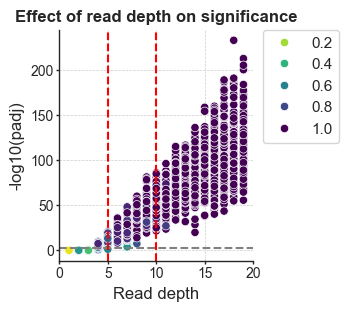

In [42]:
experiment_df = pd.read_csv(f'{data_dir}Experiment2_ReadDepth_{label}.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Read depth'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df = experiment_df.reset_index()
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)
ax = sns.scatterplot(experiment_df, x='Read depth', y='-log10(P.adj)', hue='accuracy', palette='viridis_r')
set_ax_params(ax)
plt.xlim((0, 20))
plt.xlabel('Read depth')
plt.ylabel('-log10(padj)')
plt.title('Effect of read depth on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 5, color = 'red', linestyle = '--') #axis='y', 
plt.axvline(x = 10, color = 'red', linestyle = '--') #axis='y', 
plt.savefig(f'{fig_dir}Experiment2_{label}.svg')
plt.show()

In [43]:
f5_10 = experiment_df[experiment_df['Read depth'] > 10]
np.mean(f5_10['accuracy'].values)

0.9970481256556624

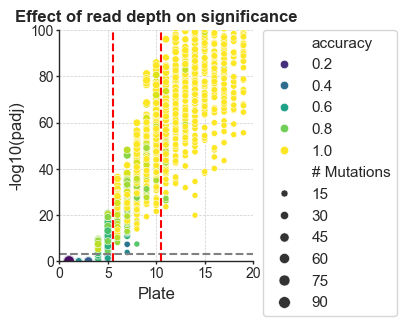

In [44]:
experiment_df = pd.read_csv(f'{data_dir}Experiment2_ReadDepth_{label}.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Plate'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df = experiment_df.reset_index()
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

ax = sns.scatterplot(experiment_df, x='Plate', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")
set_ax_params(ax)
plt.xlabel('Plate')
plt.ylabel('-log10(padj)')
plt.xlim((0, 20))
plt.ylim((0, 100))

plt.title('Effect of read depth on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.axvline(x = 5.5, color = 'red', linestyle = '--') #axis='y', 
plt.axvline(x = 10.5, color = 'red', linestyle = '--') #axis='y', 

plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.savefig(f'{fig_dir}Experiment2_version2_{label}.svg')
plt.show()

In [45]:
# Get for read depth between 0-5, 6-10, 10-20
for read_depth in range(1, 11):
    u.dp(['Read Depth:', read_depth, np.nanmean(experiment_df[experiment_df['Alignment_count'] == read_depth]['accuracy'].values)])

for read_depth in range(10, 90, 10):
    u.dp(['Read Depth:', read_depth, np.nanmean(experiment_df[experiment_df['Alignment_count'] == read_depth]['accuracy'].values)])


--------------------------------------------------------------------------------
                       Read Depth:	1	0.15156412970582878	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       Read Depth:	2	0.6291303168400102	                        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       Read Depth:	3	0.4260014427230859	                        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       Read Depth:	4	0.8597396842994752	                        
--------------------------------------------------------------------------------
----------------------------

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_70709/3950413185.py:6: RuntimeWarning: Mean of empty slice
  u.dp(['Read Depth:', read_depth, np.nanmean(experiment_df[experiment_df['Alignment_count'] == read_depth]['accuracy'].values)])


## Experiment 3: effect of sequence length on significance


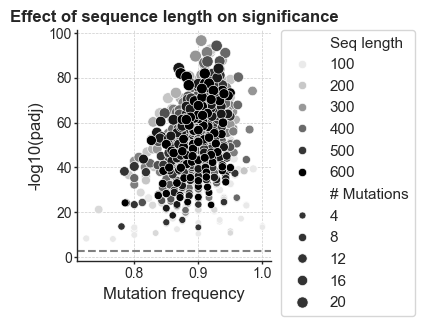

In [46]:
experiment_df = pd.read_csv(f'{data_dir}Experiment3_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Seq length'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Seq length', palette='Greys', 
                     size="# Mutations")#
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Effect of sequence length on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.savefig(f'{fig_dir}Experiment3_{label}.svg')
plt.show()

## Experiment 4: effect of frequency cutoff

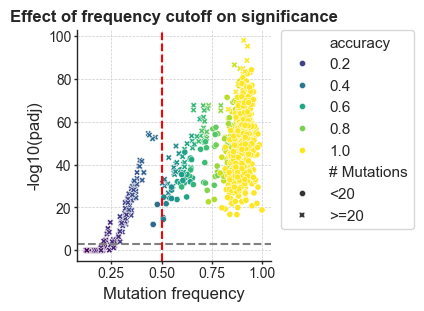

In [47]:
experiment_df = pd.read_csv(f'{data_dir}Experiment4_{label}.csv')
experiment_df = experiment_df[
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Freq'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df['# Mutations'] = [f'<20' if v < 20 else f'>=20' for v in experiment_df['# Mutations']]
experiment_df = experiment_df.reset_index()
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     style="# Mutations", style_order=['<20', '>=20'], s=20)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Effect of frequency cutoff on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 
plt.savefig(f'{fig_dir}Experiment4_{label}.svg')
plt.show()

## Experiment 5: ePCR mutation rate

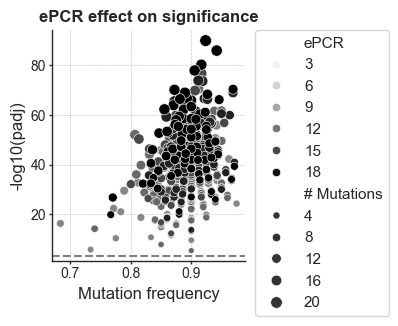

In [49]:
experiment_df = pd.read_csv(f'{data_dir}Experiment5_{label}.csv')
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['ePCR'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='ePCR', palette='Greys', 
                     size="# Mutations")
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('ePCR effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.savefig(f'{fig_dir}Experiment5_{label}.svg')
plt.show()

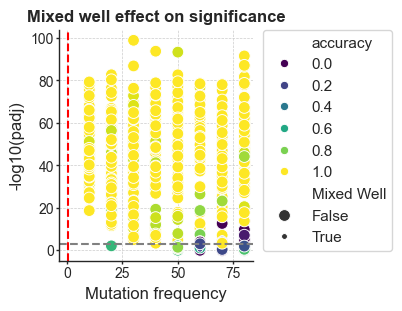

In [50]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='mixedWell', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     #palette=['grey', 'orange'], 
                     size="Mixed Well")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_{label}.svg')
plt.show()

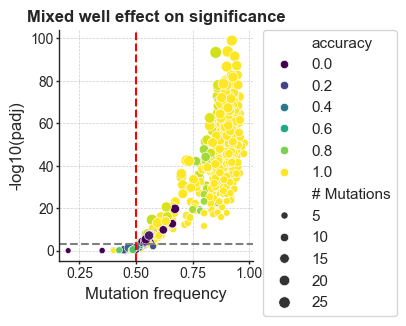

In [63]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_version2_{label}.svg')
plt.show()

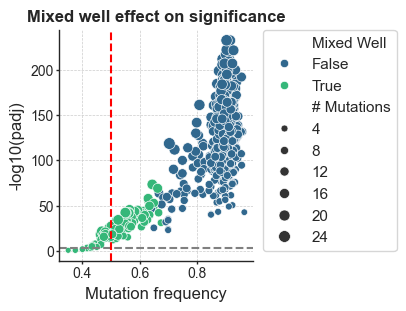

In [65]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_20_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Mixed Well', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_{label}.svg')
plt.show()

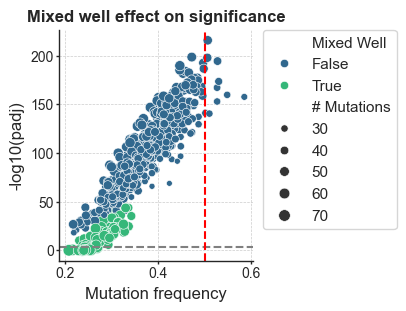

In [67]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_20_0.2_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Mixed Well', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_0.2_{label}.svg')
plt.show()

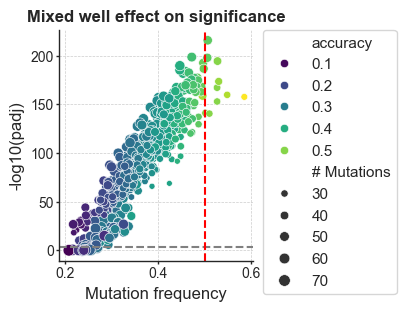

In [68]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_20_0.2_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_20_0.2_accuracy_{label}.svg')
plt.show()

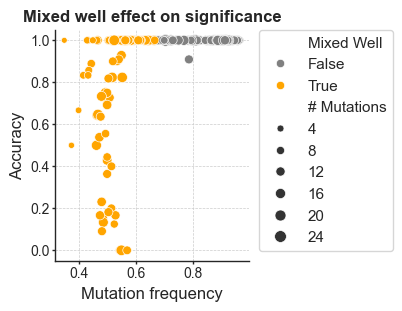

In [62]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='accuracy', hue='Mixed Well', palette=['grey', 'orange'], 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('Accuracy')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.savefig(f'{fig_dir}Experiment6_{label}.svg')
plt.show()

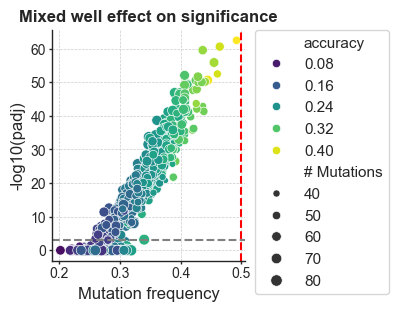

In [55]:
experiment_df = pd.read_csv(f'{data_dir}Experiment6_freq_0.2_{label}.csv')

experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df.replace([np.inf, -np.inf], 320, inplace=True)

experiment_df['mixedWell'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(str(v).split('_')) for v in experiment_df['Variant'].values]
#experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df['Mixed Well'] = [c for c in experiment_df['Mixed Well'].values]

experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='accuracy', palette='viridis', 
                     size="# Mutations")#]# , style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Mixed well effect on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y = significance, color = 'grey', linestyle = '--') #axis='y', 
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.axvline(x = 0.5, color = 'red', linestyle = '--') #axis='y', 

plt.savefig(f'{fig_dir}Experiment6_freq_0.2_{label}.svg')
plt.show()

In [57]:
print(len(parent_sequence))

612


In [58]:
612*0.02

12.24

(array([  6.,  23.,  77., 135., 222., 177.,  73.,  34.,  18.,   3.]),
 array([32. , 37.2, 42.4, 47.6, 52.8, 58. , 63.2, 68.4, 73.6, 78.8, 84. ]),
 <BarContainer object of 10 artists>)

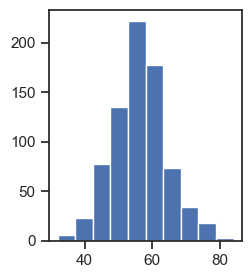

In [61]:
plt.hist(experiment_df['# Mutations'].values)